Please view the "College_Data_Manipulation" notebook before reviewing this one. This notebook will demonstrate simple steps to predict college admissions using ensemble (Randon Forest Classifier) technique.

In [1]:
# Import relevant modules and load your dataframe.

import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import binarize
from sklearn.ensemble import RandomForestClassifier
%pylab inline

df = pd.read_csv('/Users/Haebichan/Desktop/Processed Harvard Data.csv')

Populating the interactive namespace from numpy and matplotlib


In [2]:
df.head()

,Unnamed: 0,gender,type_of_high_school,state,unweighted_gpa,sat_math,sat_reading,sat_writing,act_total,school_ranking,decision,sat_total
0,0,0,0,1,4.00,770.0,800.0,730.0,35.0,0,1,2300.0
1,1,0,1,1,4.00,750.0,740.0,740.0,33.0,2,0,2230.0
2,2,0,0,1,4.00,750.0,750.0,800.0,35.0,2,1,2300.0
3,3,0,0,1,4.00,700.0,710.0,750.0,34.0,1,0,2160.0
4,4,0,0,1,3.74,620.0,640.0,670.0,29.0,2,0,1930.0


In [3]:
# Get rid of the first column. Also, get rid of sat_math / sat_reading / sat_writing columns. One column representing total SAT score is enough for prediction and doesn't take away from the precision of the precision. Next, reposition sat_total column so that the decision column (our target) is the last one in the dataframe.

df = df.iloc[:,1:]

cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

df.drop('sat_math sat_reading sat_writing'.split(), 1, inplace=True)

df.head()

,sat_total,gender,type_of_high_school,state,unweighted_gpa,act_total,school_ranking,decision
0,2300.0,0,0,1,4.00,35.0,0,1
1,2230.0,0,1,1,4.00,33.0,2,0
2,2300.0,0,0,1,4.00,35.0,2,1
3,2160.0,0,0,1,4.00,34.0,1,0
4,1930.0,0,0,1,3.74,29.0,2,0


In [4]:
# Split and train your data.
X = df.iloc[:,:-1]
Y = df['decision']

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3)

In [5]:
# Optimize relevant parameters of Random Forest using RandomSearchCV

model = RandomForestClassifier()
n_estimators_range = range(1,70)
min_samples_split_range = range(2,50)
min_samples_leaf_range = range(2,50)
max_depth_range = range(1,20)

param_dist = dict({
    'n_estimators': n_estimators_range,
    'min_samples_split': min_samples_split_range,
    'min_samples_leaf': min_samples_leaf_range,
    'max_depth': max_depth_range,
})


search = RandomizedSearchCV(model, param_dist, n_iter = 50, cv = 10, scoring = 'accuracy')
search.fit(X,Y)

print('Best Params: {}'.format(search.best_params_))
print('Best Score: {}'.format(search.best_score_))
print('Best Estimator: {}'.format(search.best_estimator_))

Best Params: {'n_estimators': 50, 'min_samples_split': 20, 'min_samples_leaf': 13, 'max_depth': 19}
Best Score: 0.740608228980322
Best Estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=19, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=13, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [6]:
# Instantiate the estimator using found paramters 

model = RandomForestClassifier(n_estimators = 50, min_samples_split = 20, min_samples_leaf = 13, max_depth = 19)
model.fit(X,Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=19, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=13, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

(array([ 7.,  7., 11., 16., 12., 15., 17., 15., 16., 11., 12.,  8.,  9.,
         2.,  2.,  0.,  1.,  2.,  2.,  3.]),
 array([0.0619189 , 0.09364805, 0.1253772 , 0.15710635, 0.1888355 ,
        0.22056465, 0.2522938 , 0.28402295, 0.3157521 , 0.34748125,
        0.3792104 , 0.41093955, 0.4426687 , 0.47439785, 0.506127  ,
        0.53785615, 0.5695853 , 0.60131445, 0.6330436 , 0.66477275,
        0.6965019 ]),
 <a list of 20 Patch objects>)

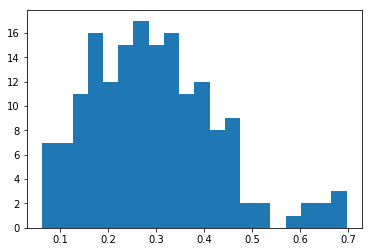

In [7]:
# Check the distribution of our target values (Admission Decisions)

y_pred_prob = model.predict_proba(x_test)[:,1]

hist(y_pred_prob, bins = 20)

The right-skewed distribution in the graph shows that the prediction threshold of around 0.22~0.25 might be more optimal than the 0.5 default value. See that our objective of correctly predicting college acceptance is one of recall, since we need to minimize the False Negative Rate. It's worse to predict rejection when it's actually an acceptance than to predict acceptance when it's a rejection. The former leads to applicants possibly not applying to specificied universities when the should have while the latter merely leads to a rejection, a frowny face, and ~$100 bucks application fee. Let us visualize the optimal prediction threshold using an ROC-curve.

Text(0,0.5,'True Positive Rate')

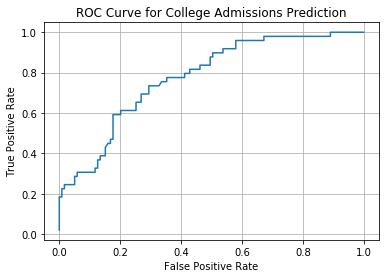

In [8]:
fpr, tpr, all_thresholds = metrics.roc_curve(y_test, y_pred_prob)
plot(fpr,tpr)
title('ROC Curve for College Admissions Prediction')
grid(True)
xlabel('False Positive Rate')
ylabel('True Positive Rate')

In [9]:
def threshold_evaluation(selected_threshold):
    print('Sensitivity: {}'.format(tpr[all_thresholds > selected_threshold][-1]))
    print('Specificity: {}'.format(1 - fpr[all_thresholds > selected_threshold][-1]))
    
def decimal_range(start, stop, increase_by):
    while start < stop: 
        yield start
        start += increase_by
        
for i in decimal_range(0.22, 0.26, 0.01):
    i = round(i, 2)
    print(threshold_evaluation(i), i)

Sensitivity: 0.9591836734693877
Specificity: 0.4201680672268907
None 0.22
Sensitivity: 0.9183673469387755
Specificity: 0.46218487394957986
None 0.23
Sensitivity: 0.8979591836734694
Specificity: 0.4957983193277311
None 0.24
Sensitivity: 0.8367346938775511
Specificity: 0.5042016806722689
None 0.25


In [10]:
# Seeing that 0.22 provided the best rate, change the prediction threshold using binarize to increase the sensitivity rate with this given number. Your optimal prediction threshold will vary. 

y_pred_binarized = binarize([y_pred_prob], 0.22)[0]

In [11]:
# Gauge the results by comparing the two confusion matrices (with and without shifted prediction threshold).

y_pred = model.predict(x_test)

cf_matrix = metrics.confusion_matrix(y_test, y_pred)
new_cf_matrix = metrics.confusion_matrix(y_test, y_pred_binarized)

print("Original Confusion Matrix: {}".format(cf_matrix))
print("New Confusion Matrix: {}".format(new_cf_matrix))

Original Confusion Matrix: [[118   1]
 [ 39  10]]
New Confusion Matrix: [[50 69]
 [ 2 47]]


The first confusion matrix shows a sensitivity rate of 20% (10 / (10+39)). The second one with the changed prediction threshold displays a sensitivity rate of 95% (47 / (47+2)).

In [12]:
# There are many metrics to measure the performance of the classifier. 


# Area Under the Curve or AUC (performance of a classifier as an alternative to classification accuracy)
print("AUC: ", metrics.roc_auc_score(y_test, y_pred_prob))

# Cross-Validated AUC (AUC with 10 k-folds cross validation)
c_val_auc = cross_val_score(model, X,Y, cv=10, scoring= 'roc_auc').mean()
print("Cross-Validated AUC", c_val_auc)


# Cross-Validated Score (10 k-folds cross validation)
c_val_score = cross_val_score(model, X,Y, scoring = 'accuracy',cv = 10)
print("Cross-Validation Score (10-K folds) %s"% c_val_score.mean())

# Test Accuracy Score
print("Accuracy Score: ", model.score(x_test,y_test))


AUC:  0.776367689933116
Cross-Validated AUC 0.6594692684766214
Cross-Validation Score (10-K folds) 0.7389097744360902
Accuracy Score:  0.7619047619047619


In [13]:
# Get your prediction for college admissions, using a function that can be created however you like.

def get_inputs(): 
    print("\nPlease provide the gender (Male or Female):")
    gender = input('Gender: ')
    if gender == 'Male':
        gender = 1
    elif gender == 'Female':
        gender = 0

    print('\nPlease provide the type of high school (Private or Public): ')
    school_type = input('School Type: ')
    if school_type == 'Private':
        school_type = 1
    if school_type == 'Public':
        school_type = 0

    print('\nPlease type either "In-State" or "Out-of-State" for type of application: ')
    in_out_state = input('Application Type: ')
    if in_out_state == 'In-State':
        in_out_state = 0
    elif in_out_state == 'Out-of-State':
        in_out_state = 1

    print('\nPlease provide the Unweighted GPA Score: ')
    GPA = float(input('Total of 4.0: '))

    print('\nPlease provide the total SAT Score (2400 Max): ')
    SAT = int(input('SAT Score: '))

    print('\nPlease provide the total ACT Score (36 Max): ')
    ACT = int(input('ACT Score: '))

    print('\nPlease provide the school ranking: ')
    ranking = input('Top 1%, Top 5%, Top 10%, Top 25%, Top 50%: ')
    if ranking == 'Top 1%':
        ranking = 0
    if ranking == 'Top 5%':
        ranking = 1
    if ranking == 'Top 10%':
        ranking = 2
    if ranking == 'Top 25%':
        ranking = 3
    if ranking == 'Top 50%':
        ranking = 4
    
    return gender, school_type, in_out_state, GPA, SAT, ACT, ranking

prediction = model.predict([get_inputs()])


if prediction[0] == 1:
    print("Our machine has predicted 'Admission' based on the profile given.")
elif prediction[0] == 0:
    print("Our machine has predicted 'Rejection' based on the profile given.")
else:
    print("An error has occurred. Please try again.")



Please provide the gender (Male or Female):
Gender: Female

Please provide the type of high school (Private or Public): 
School Type: Private

Please type either "In-State" or "Out-of-State" for type of application: 
Application Type: In-State

Please provide the Unweighted GPA Score: 
Total of 4.0: 3.5

Please provide the total SAT Score (2400 Max): 
SAT Score: 2100

Please provide the total ACT Score (36 Max): 
ACT Score: 35

Please provide the school ranking: 
Top 1%, Top 5%, Top 10%, Top 25%, Top 50%: Top 5%
Our machine has predicted 'Rejection' based on the profile given.
